## Phylogenetic error assessment

We analyzed prediction errors across 102 genera to test whether model performance was systematically structured by phylogeny

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
import json
import torch
import sys
from typing import Union, List, Dict, Any, Optional
from tqdm import tqdm
import json
from collections import defaultdict
import json
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Paths
PROJECT_DIR = Path.cwd().parent.parent.parent
if str(PROJECT_DIR) not in sys.path:
    sys.path.append(str(PROJECT_DIR))

from anglecam import AngleCam

IMAGES_DIR = PROJECT_DIR / "data" / "01_Training_Validation_Data" / "image_data"
DATA_PATH = PROJECT_DIR / "data" / "01_Training_Validation_Data" / "splits"

PHYLO_RESULTS_PATH = PROJECT_DIR / "data" / "03_Model_Outputs" / "predictions" / "phylogenetic_error_assesment"
FIGURES_PATH = PROJECT_DIR / "data" / "other" / "figures" / "results" 

OUTPUT_DIR = PROJECT_DIR / "data" / "03_Model_Outputs" / "checkpoint"
CHECKPOINT_PATH = OUTPUT_DIR / "AngleCamV2.pth"

assert CHECKPOINT_PATH.exists(), f"Checkpoint path not found: {CHECKPOINT_PATH}"
assert DATA_PATH.exists(), f"Data path not found: {DATA_PATH}"
assert PHYLO_RESULTS_PATH.exists(), f"Phylogenetic results path not found: {PHYLO_RESULTS_PATH}"
assert FIGURES_PATH.exists(), f"Figures path not found: {FIGURES_PATH}"
assert OUTPUT_DIR.exists(), f"Output directory not found: {OUTPUT_DIR}"
assert IMAGES_DIR.exists(), f"Images directory not found: {IMAGES_DIR}"

# Load data
phylo_data = pd.read_csv(DATA_PATH / "phylo.csv", sep=",")

In [3]:
# Load pretrained model
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

config_overrides = {
    "training": {
        "output_dir": "data/model/output" 
    }
}

anglecam = AngleCam.from_checkpoint(
    str(CHECKPOINT_PATH), 
    config_overrides=config_overrides
)
anglecam.device = device

# Move model to selected device for later inference
anglecam.model.to(device)

print("Model loaded and ready for inference.")

Using device: cuda:0


Using cache found in /home/lk1167/.cache/torch/hub/facebookresearch_dinov2_main


Model loaded and ready for inference.


In [3]:
def batch_predict(
    model,
    input_data: Union[str, Path, pd.DataFrame],
    images_dir: Path,
    output_path: Optional[Path] = None,
    batch_size: int = 128,
) -> List[Dict[str, Any]]:
    """
    Batch prediction function.

    Args:
        model: AngleCam model instance with predict() method
        input_data: Either a CSV file path/DataFrame with 'filename' column, or single image path
        images_dir: Directory where images are stored (IMAGES_DIR)
        output_path: Optional path to save results as JSON
        batch_size: Number of images to process before clearing GPU cache (default: 128)

    Returns:
        List of prediction results
    """

    def load_labels_robust(labels_filepath: Path) -> tuple:
        """Load labels with automatic separator detection."""
        try:
            # First try with space separator
            labels_df = pd.read_csv(labels_filepath, sep=" ", header=None)
            labels = labels_df.iloc[0, :].to_numpy(dtype=float)
        except (ValueError, TypeError):
            try:
                # If space fails, try comma separator
                labels_df = pd.read_csv(labels_filepath, sep=",", header=None)
                labels = labels_df.iloc[0, :].to_numpy(dtype=float)
            except (ValueError, TypeError):
                try:
                    # Try automatic separator detection
                    labels_df = pd.read_csv(labels_filepath, header=None)
                    labels = labels_df.iloc[0, :].to_numpy(dtype=float)
                except Exception as e:
                    raise ValueError(
                        f"Could not parse labels file with any separator: {e}"
                    )

        # Normalize and calculate mean
        labels = labels / labels.sum()
        labels_mean = np.sum(np.linspace(0, 90, 43) * labels)
        return labels_mean, labels.tolist()

    results = []

    # Handle input data and create lookup for genus/species
    genus_species_lookup = {}
    if isinstance(input_data, (str, Path)):
        input_path = Path(input_data)
        if input_path.suffix == ".csv":
            df = pd.read_csv(input_path)
            filenames = df["filename"].tolist()
            # Create lookup dictionary for genus and species
            if "Genus" in df.columns and "species" in df.columns:
                for _, row in df.iterrows():
                    genus_species_lookup[row["filename"]] = {
                        "genus": row["Genus"],
                        "species": row["species"]
                    }
        else:
            filenames = [input_path.name]
    elif isinstance(input_data, pd.DataFrame):
        df = input_data
        filenames = df["filename"].tolist()
        # Create lookup dictionary for genus and species
        if "Genus" in df.columns and "species" in df.columns:
            for _, row in df.iterrows():
                genus_species_lookup[row["filename"]] = {
                    "genus": row["Genus"],
                    "species": row["species"]
                }
    else:
        raise ValueError(f"Unsupported input type: {type(input_data)}")

    print(f"Processing {len(filenames)} images in batches of {batch_size}")

    # Process in batches
    for i in tqdm(range(0, len(filenames), batch_size), desc="Processing batches"):
        batch_filenames = filenames[i : i + batch_size]

        for filename in batch_filenames:
            try:
                # Image filepath
                image_filepath = images_dir / filename

                if not image_filepath.exists():
                    print(f"Warning: Image not found: {image_filepath}")
                    results.append(
                        {"filename": filename, "error": "Image file not found"}
                    )
                    continue

                # Get genus and species from lookup
                genus = genus_species_lookup.get(filename, {}).get("genus", "Unknown")
                species = genus_species_lookup.get(filename, {}).get("species", "Unknown")

                # Check if labels exist
                labels_filepath = images_dir / (filename.split(".")[0] + "_sim.csv")
                sim_data = {"distribution": None, "mean_angle": None}

                if labels_filepath.exists():
                    try:
                        labels_mean, labels_distribution = load_labels_robust(
                            labels_filepath
                        )
                        sim_data = {
                            "distribution": labels_distribution,
                            "mean_angle": labels_mean
                        }
                    except Exception as e:
                        print(f"Warning: Could not load labels for {filename}: {e}")

                # Predict the angle
                pred_result = model.predict(image_filepath)
                
                # Structure prediction data
                pred_data = {
                    "distribution": pred_result["angle_distribution"],
                    "mean_angle": pred_result["predicted_mean_leaf_angle"]
                }

                # Create result dictionary in the new format
                result = {
                    "filename": filename,
                    "genus": genus,
                    "species": species,
                    "predicted_distribution": pred_data['distribution'],
                    "predicted_mean_angle": pred_data['mean_angle'],
                    "reference_distribution": sim_data['distribution'],
                    "reference_mean_angle": sim_data['mean_angle'],
                }

                results.append(result)

            except Exception as e:
                print(f"Error processing {filename}: {e}")
                error_result = {"filename": filename, "error": str(e)}
                results.append(error_result)

        # Clear GPU cache between batches to manage memory
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # Save results if output path provided
    if output_path:
        output_path = Path(output_path)
        output_path.parent.mkdir(parents=True, exist_ok=True)
        with open(output_path, "w") as f:
            json.dump(results, f, indent=2)
        print(f"Results saved to {output_path}")

    print(f"Completed processing {len(results)} images")
    return results


# Example usage:
# results = batch_predict(anglecam, training_data, IMAGES_DIR, output_path="results.json")
# results = batch_predict(anglecam, "path/to/filenames.csv", IMAGES_DIR)
# results = batch_predict(anglecam, single_image_path, IMAGES_DIR)

In [ ]:
batch_predict(anglecam, phylo_data, IMAGES_DIR, output_path=PHYLO_RESULTS_PATH / "phylogenetic_error_results_anglecam_v2_raw.json")

Processing 306 images in batches of 128


Processing batches: 100%|██████████| 3/3 [00:15<00:00,  5.13s/it]

Results saved to /mnt/data/lk1167/projects/AngleCamV2/data/paper/results/phylo/phylogenetic_error_results_anglecam_v2.json
Completed processing 306 images


[{'filename': 'l_343_o2_TLC00016_image_000004.png',
  'genus': 'Tilia',
  'species': 'Tilia platyphyllos',
  'predicted_distribution': [0.0015832808567211032,
   0.0019227747106924653,
   0.0022953141015022993,
   0.002647686516866088,
   0.003106264863163233,
   0.0030075281392782927,
   0.0038542288821190596,
   0.004484797362238169,
   0.006595940329134464,
   0.005799502599984407,
   0.008026289753615856,
   0.0073307836428284645,
   0.008731095120310783,
   0.01069988775998354,
   0.012765523046255112,
   0.015041421167552471,
   0.015507102943956852,
   0.017843132838606834,
   0.019725365564227104,
   0.021836603060364723,
   0.024259906262159348,
   0.02673957124352455,
   0.023950761184096336,
   0.02808181382715702,
   0.030141329392790794,
   0.03153839707374573,
   0.03473043441772461,
   0.033840078860521317,
   0.038211409002542496,
   0.03661445155739784,
   0.03940681740641594,
   0.03915274888277054,
   0.04107692092657089,
   0.040451426059007645,
   0.041412368416786

### Create csv file containing the prediction errors per genus

Further processing will be done in R

Steps:
- Generate tree
- Match prediction error to tree
- Calculate Pagel's lambda
- Calculate Moran's I

In [5]:
def json_to_genus_csv(json_file_path: str, output_csv_path: str) -> pd.DataFrame:
    # Load JSON results
    with open(json_file_path, "r") as f:
        results = json.load(f)

    # Group results by genus
    genus_groups = defaultdict(list)

    for result in results:
        genus = result.get("genus", None)
        # Skip if genus is missing or invalid
        if genus and genus not in [None, "nan", "", "None"]:
            # Calculate absolute error
            predicted_angle = result.get("predicted_mean_angle", 0)
            reference_angle = result.get("reference_mean_angle", 0)
            abs_error = abs(predicted_angle - reference_angle)

            genus_groups[genus].append(abs_error)

    # Calculate statistics for each genus
    genus_stats = []
    for genus, errors in genus_groups.items():
        genus_stats.append(
            {
                "genus": genus,
                "mean_abs_error": np.mean(errors),
                "sample_size": len(errors),
            }
        )

    # Create DataFrame and sort by genus name
    df = pd.DataFrame(genus_stats)
    df = df.sort_values("genus").reset_index(drop=True)

    # Save to CSV
    df.to_csv(output_csv_path, index=False)
    print(f"Genus-level statistics saved to: {output_csv_path}")
    print(f"Summary: {len(df)} genera, {df['sample_size'].sum()} total samples")

    return df


# Version with additional statistics
def json_to_genus_csv_extended(
    json_file_path: str, output_csv_path: str
) -> pd.DataFrame:
    # Load JSON results
    with open(json_file_path, "r") as f:
        results = json.load(f)

    # Group results by genus
    genus_groups = defaultdict(list)

    for result in results:
        genus = result.get("genus", None)
        # Skip if genus is missing or invalid
        if genus and genus not in [None, "nan", "", "None"]:
            predicted_angle = result.get("predicted_mean_angle", 0)
            reference_angle = result.get("reference_mean_angle", 0)

            genus_groups[genus].append(
                {
                    "predicted": predicted_angle,
                    "reference": reference_angle,
                    "abs_error": abs(predicted_angle - reference_angle),
                    "error": predicted_angle - reference_angle,
                    "species": result.get("species", ""),
                }
            )

    # Calculate statistics for each genus
    genus_stats = []
    for genus, data in genus_groups.items():
        abs_errors = [d["abs_error"] for d in data]
        errors = [d["error"] for d in data]
        predicted_angles = [d["predicted"] for d in data]
        reference_angles = [d["reference"] for d in data]
        species_set = set(d["species"] for d in data if d["species"])

        genus_stats.append(
            {
                "genus": genus,
                "mean_abs_error": np.mean(abs_errors),
                "sample_size": len(data),
                "std_abs_error": np.std(abs_errors),
                "rmse": np.sqrt(np.mean([e**2 for e in errors])),
                "bias": np.mean(errors),
                "mean_predicted_angle": np.mean(predicted_angles),
                "mean_reference_angle": np.mean(reference_angles),
                "species_count": len(species_set),
            }
        )

    # Create DataFrame and sort by mean absolute error
    df = pd.DataFrame(genus_stats)
    df = df.sort_values("mean_abs_error").reset_index(drop=True)

    # Save to CSV
    df.to_csv(output_csv_path, index=False)
    print(f"Genus-level statistics saved to: {output_csv_path}")
    print(f"Summary: {len(df)} genera, {df['sample_size'].sum()} total samples")

    # Print top and bottom performers
    print(f"\nBest performing genera (lowest MAE):")
    print(df.head(3)[["genus", "mean_abs_error", "sample_size"]].to_string(index=False))
    print(f"\nWorst performing genera (highest MAE):")
    print(df.tail(3)[["genus", "mean_abs_error", "sample_size"]].to_string(index=False))

    return df


# Simple usage function
def create_genus_summary_csv(json_path: str, csv_path: str = None) -> pd.DataFrame:
    if csv_path is None:
        csv_path = json_path.replace(".json", "_genus_summary.csv")

    return json_to_genus_csv(json_path, csv_path)

In [ ]:
json_file = PHYLO_RESULTS_PATH / "phylogenetic_error_results_anglecam_v2_raw.json"
output_file = PHYLO_RESULTS_PATH / "phylogenetic_error_results_anglecam_v2_genus_statistics.csv"

phylo_results = json_to_genus_csv_extended(json_file, output_file)

Genus-level statistics saved to: /mnt/data/lk1167/projects/AngleCamV2/data/paper/results/phylo/phylogenetic_error_results_anglecam_v2_genus_statistics.csv
Summary: 102 genera, 306 total samples

Best performing genera (lowest MAE):
     genus  mean_abs_error  sample_size
     Pilea        1.140980            3
   Goudaea        1.426083            3
Nothofagus        1.441837            3

Worst performing genera (highest MAE):
  genus  mean_abs_error  sample_size
Arbutus       14.484966            3
   Olea       14.717023            3
  Pinus       26.084535            3


In [7]:
phylo_results

,genus,mean_abs_error,sample_size,std_abs_error,rmse,bias,mean_predicted_angle,mean_reference_angle,species_count
0,Pilea,1.140980,3,0.623450,1.300202,-0.049199,72.708323,72.757522,1
1,Goudaea,1.426083,3,1.479598,2.054976,-1.158993,60.146992,61.305985,1
2,Nothofagus,1.441837,3,0.619112,1.569137,1.441837,12.053506,10.611669,1
3,Tradescantia,1.513226,3,1.409700,2.068117,-1.259559,68.279747,69.539306,1
4,Diospyros,1.667610,3,1.307827,2.119276,-0.957259,36.944756,37.902014,1
...,...,...,...,...,...,...,...,...,...
97,Simmondsia,13.246396,3,5.869239,14.488443,-13.246396,57.408269,70.654665,1
98,Lavandula,13.994437,3,9.613016,16.978055,-10.433235,40.010192,50.443427,1
99,Arbutus,14.484966,3,6.511339,15.881176,10.131543,33.978102,23.846559,1
100,Olea,14.717023,3,10.523509,18.092402,14.717023,47.764544,33.047521,1


In [9]:
# Calculate distribution statistics for mean absolute errors
# Calculate percentiles and summary statistics
mae_values = phylo_results['mean_abs_error']

# Basic statistics
min_mae = mae_values.min()
max_mae = mae_values.max()
median_mae = mae_values.median()
mean_mae = mae_values.mean()

# Quartiles
q25 = mae_values.quantile(0.25)
q75 = mae_values.quantile(0.75)
iqr = q75 - q25

# Additional percentiles
q10 = mae_values.quantile(0.10)
q90 = mae_values.quantile(0.90)

print("Mean Absolute Error Distribution Statistics:")
print("=" * 50)
print(f"Range: {min_mae:.2f}° to {max_mae:.2f}°")
print(f"Mean: {mean_mae:.2f}°")
print(f"Median: {median_mae:.2f}°")
print(f"Standard deviation: {mae_values.std():.2f}°")
print()
print("Percentiles:")
print(f"10th percentile: {q10:.2f}°")
print(f"25th percentile (Q1): {q25:.2f}°")
print(f"50th percentile (Median): {median_mae:.2f}°")
print(f"75th percentile (Q3): {q75:.2f}°")
print(f"90th percentile: {q90:.2f}°")
print()
print(f"Interquartile range (IQR): {q25:.1f}° to {q75:.1f}°")
print(f"IQR span: {iqr:.2f}°")
print()

# Count genera in different ranges
count_1_5 = len(mae_values[(mae_values >= 1) & (mae_values <= 5)])
count_5_10 = len(mae_values[(mae_values > 5) & (mae_values <= 10)])
count_5_11 = len(mae_values[(mae_values > 5) & (mae_values <= 11)])
count_5_12 = len(mae_values[(mae_values > 5) & (mae_values <= 12)])
count_10_plus = len(mae_values[mae_values > 10])

total_genera = len(mae_values)

print("Distribution across ranges:")
print(f"1-5°: {count_1_5} genera ({count_1_5/total_genera*100:.1f}%)")
print(f"5-10°: {count_5_10} genera ({count_5_10/total_genera*100:.1f}%)")
print(f"5-11°: {count_5_11} genera ({count_5_11/total_genera*100:.1f}%)")
print(f"5-12°: {count_5_12} genera ({count_5_12/total_genera*100:.1f}%)")
print(f">10°: {count_10_plus} genera ({count_10_plus/total_genera*100:.1f}%)")
print()

print("=" * 50)
print(f"Mean absolute errors ranged from {min_mae:.0f}° to {max_mae:.0f}°, ")
print(f"with the majority of genera falling between {q25:.0f}° and {q75:.0f}°")
print(f"(interquartile range, covering {count_5_11} of {total_genera} genera, {count_5_11/total_genera*100:.0f}%)")

Mean Absolute Error Distribution Statistics:
Range: 1.14° to 26.08°
Mean: 7.24°
Median: 7.27°
Standard deviation: 3.80°

Percentiles:
10th percentile: 2.77°
25th percentile (Q1): 4.36°
50th percentile (Median): 7.27°
75th percentile (Q3): 9.71°
90th percentile: 11.07°

Interquartile range (IQR): 4.4° to 9.7°
IQR span: 5.35°

Distribution across ranges:
1-5°: 33 genera (32.4%)
5-10°: 44 genera (43.1%)
5-11°: 56 genera (54.9%)
5-12°: 63 genera (61.8%)
>10°: 25 genera (24.5%)

Mean absolute errors ranged from 1° to 26°, 
with the majority of genera falling between 4° and 10°
(interquartile range, covering 56 of 102 genera, 55%)


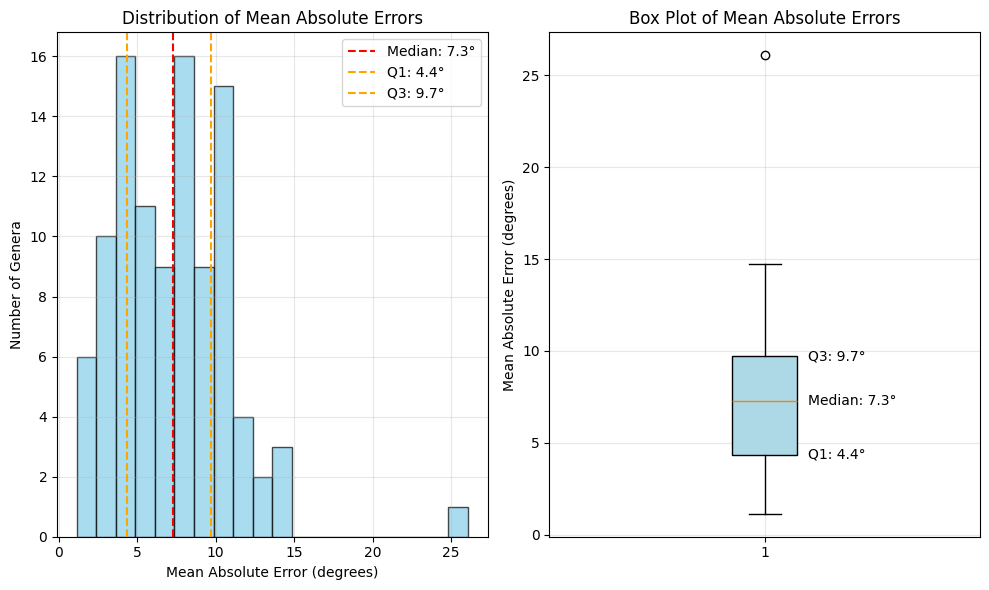


Best performing genera (lowest MAE):
       genus  mean_abs_error  sample_size
       Pilea        1.140980            3
     Goudaea        1.426083            3
  Nothofagus        1.441837            3
Tradescantia        1.513226            3
   Diospyros        1.667610            3

Worst performing genera (highest MAE):
     genus  mean_abs_error  sample_size
Simmondsia       13.246396            3
 Lavandula       13.994437            3
   Arbutus       14.484966            3
      Olea       14.717023            3
     Pinus       26.084535            3


In [10]:
# Create visualization
plt.figure(figsize=(10, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(mae_values, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(median_mae, color='red', linestyle='--', label=f'Median: {median_mae:.1f}°')
plt.axvline(q25, color='orange', linestyle='--', label=f'Q1: {q25:.1f}°')
plt.axvline(q75, color='orange', linestyle='--', label=f'Q3: {q75:.1f}°')
plt.xlabel('Mean Absolute Error (degrees)')
plt.ylabel('Number of Genera')
plt.title('Distribution of Mean Absolute Errors')
plt.legend()
plt.grid(True, alpha=0.3)

# Box plot
plt.subplot(1, 2, 2)
box_plot = plt.boxplot(mae_values, vert=True, patch_artist=True)
box_plot['boxes'][0].set_facecolor('lightblue')
plt.ylabel('Mean Absolute Error (degrees)')
plt.title('Box Plot of Mean Absolute Errors')
plt.grid(True, alpha=0.3)

# Add text annotations on box plot
plt.text(1.1, median_mae, f'Median: {median_mae:.1f}°', va='center')
plt.text(1.1, q25, f'Q1: {q25:.1f}°', va='center')
plt.text(1.1, q75, f'Q3: {q75:.1f}°', va='center')

plt.tight_layout()
plt.show()

# Summary table of best and worst performers
print("\nBest performing genera (lowest MAE):")
print(phylo_results.head(5)[['genus', 'mean_abs_error', 'sample_size']].to_string(index=False))

print("\nWorst performing genera (highest MAE):")
print(phylo_results.tail(5)[['genus', 'mean_abs_error', 'sample_size']].to_string(index=False))